# <center> </center>
# <center> **Deep Learning** </center>
# <center> **Portfolio 2 - Wigglies**</center>

**Submitted by:**
****

*   **Riya Biju - 10000742**
*   **Harsha Sathish - 10001000**



**Q:**
In the assignment you shall implement, train, evaluate and compare at least two (can be more) neural network architectures - feed forward (fully connected, MLP) neural network and convolutional neural network. The NNs shall be implemented in Python and/or standard PyTorch API (no Tensorflow/Keras) and you shall be able to explain the models as well as your overall pipeline to get to the results in detail (data, training etc) and argue for the reasons you chose it (all operations, layers, etc.) in the final report and the oral discussion.

In [1]:
#Importing all necessary modules
import torch
import torch.nn as nn #NN module(layers, loss fn)
import torch.optim as optim #Optimization Algo(Adam)
import torch.nn.functional as F #Activation fn
from torch.utils.data import DataLoader, TensorDataset, random_split #Data handling util
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from tqdm import tqdm #For process bars epocs
import os

#We Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#Device GPU Checking
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Data Loading and Visualization

Insights from above graph:

-> Dataset is almost balanced across all labels/classes/Low Variance

-> There are 4000 samples with 40 features each / Suffient Data Samples

-> Total 10 classes 0-9

>


Training data shape: torch.Size([4000, 40])
Training labels shape: torch.Size([4000])
Number of classes: 10
Label distribution: tensor([404, 389, 388, 401, 415, 406, 411, 387, 397, 402])

Data analytics:
Min value: -4.4194
Max value: 4.5031
Mean: -0.0011
Std: 1.0007


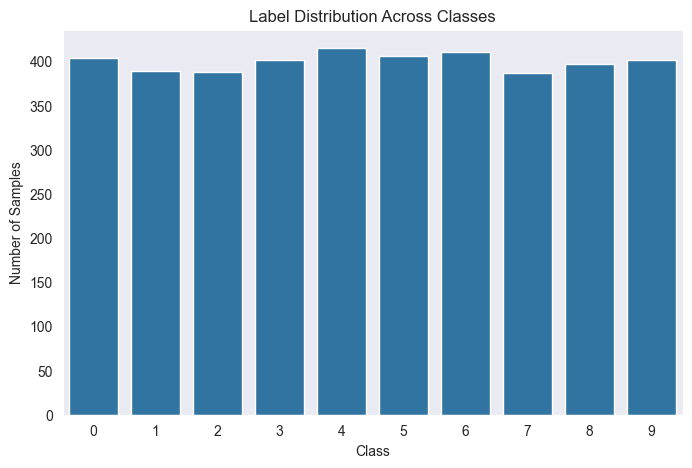

In [2]:
#Load training dataset
train_data = torch.load('trainset.pth',weights_only=False)

#Extract features and labels from loaded data into X-train and y_train
X_train = torch.stack([sample[0] for sample in train_data])  # 2D matrix
y_train = torch.tensor([sample[1] for sample in train_data])  # Converting labels to tensor

print(f"Training data shape: {X_train.shape}") # returns [no_of_samples, num_features]
print(f"Training labels shape: {y_train.shape}") #returns no of samples
print(f"Number of classes: {len(torch.unique(y_train))}") #Counts unique no of labels
print(f"Label distribution: {torch.bincount(y_train)}") #Returns spread of labels across dataset

#Here, with the label distribution, we can see that all the labels are almost equally distributed across the dataset

# Basic analytics
print(f"\nData analytics:")
print(f"Min value: {X_train.min():.4f}") #Smallest val in the dataset
print(f"Max value: {X_train.max():.4f}") #Largest val in the dataset
print(f"Mean: {X_train.mean():.4f}") #Mean val
print(f"Std: {X_train.std():.4f}") #Stndr Deviation

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train.numpy())
plt.title("Label Distribution Across Classes")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.show()

# Visualizing the Dataset

From the below diagram, we find that the images are similar to time series data i.e. things that change over time(eg : stock price, weather etc)

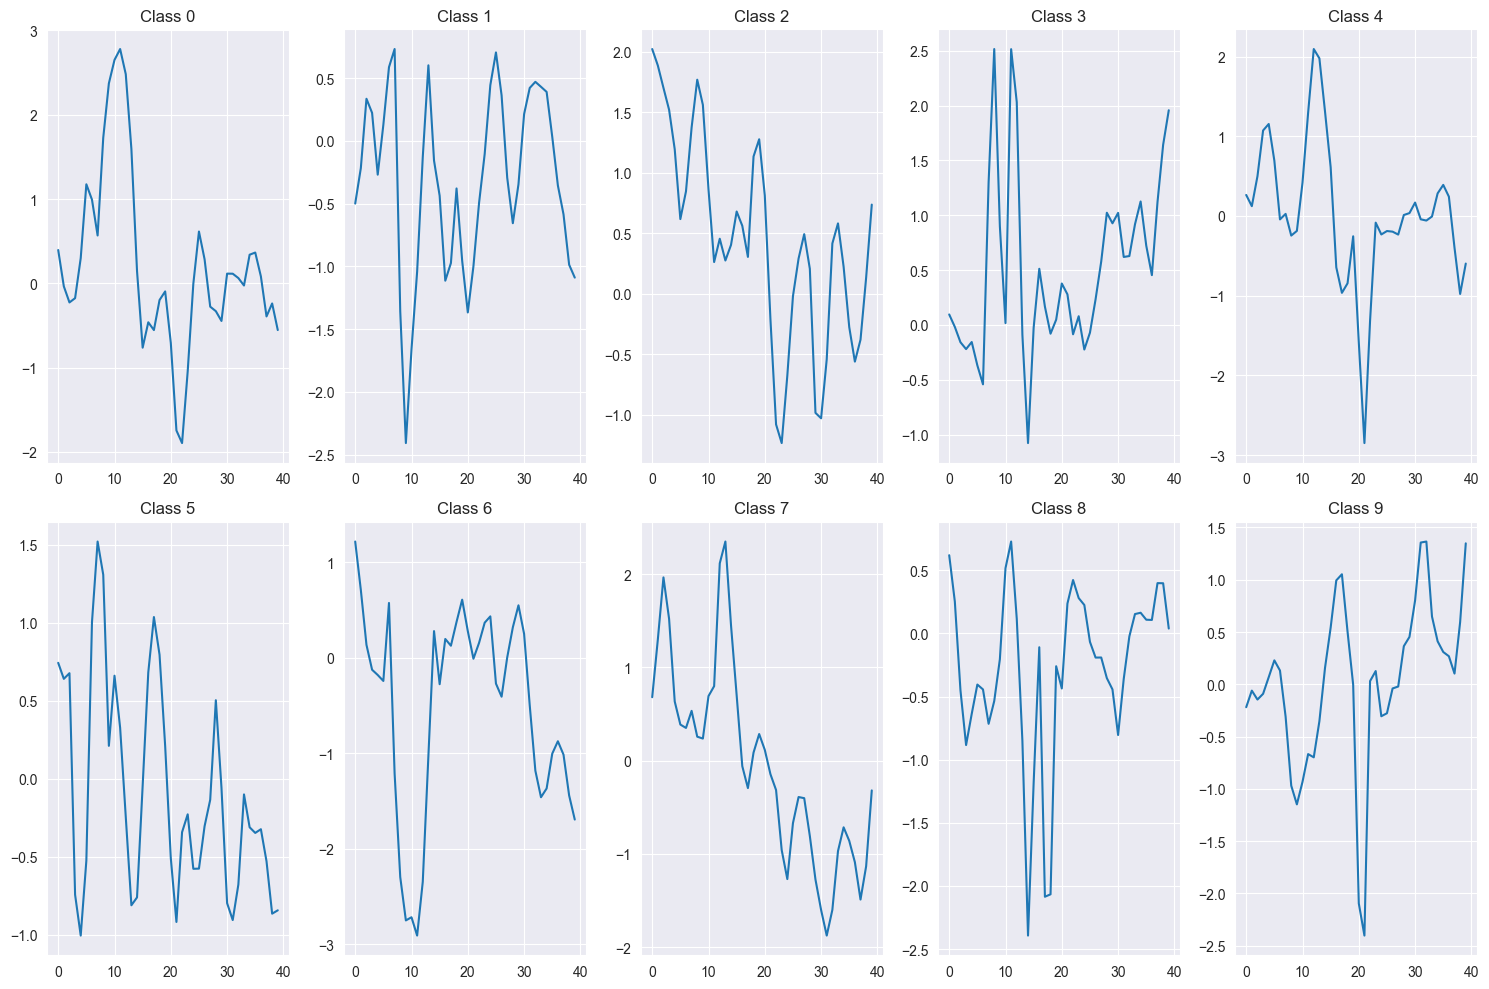

In [3]:
#Visualize the time series data, code from kaggle->
plt.figure(figsize=(15, 10)) #Create 15x10 fig
for i in range(10):
    plt.subplot(2, 5, i+1) #pos of i-th class in grid
    class_mask = y_train == i
    if class_mask.sum() > 0:
        sample_idx = torch.where(class_mask)[0][0] #first index of label i
        plt.plot(X_train[sample_idx].numpy())
        plt.title(f'Class {i}')
        plt.grid(True)
plt.tight_layout()
plt.show()

# Checking for any null values/empty values in the Dataset

We find that there are no null/empty values in the Dataset

In [4]:
#In below code, we are checking if there are any null values in the given training dataset

nan_count_features = torch.isnan(X_train).sum().item()
nan_count_labels = torch.isnan(y_train.float()).sum().item()
inf_count_features = torch.isinf(X_train).sum().item()

print(f"NaN values in features: {nan_count_features}")
print(f"NaN values in labels: {nan_count_labels}")
print(f"Infinite values in features: {inf_count_features}")

NaN values in features: 0
NaN values in labels: 0
Infinite values in features: 0


# Data Pre-Processing

• During Pre-Processing, we normalize the Dataset to have mean of 0 and variance of 1


• Why ? SCALE!! i.e. We want all features to contribute equally to prediction.

• We dont want diff SCALE of features to affect predictions

• The Normalized data sample has +-4 deviation, which is good as i/p to NN

• Data Splitting 80-20 Training vs Testing

• Splitting the Training Data and Testing Data into 32 batches each

In [5]:
# Data preprocessing
def normalize_data(X):
    """ We are Normalizing the training data to have zero mean and one variance for each sample"""
    mean = X.mean(dim=1, keepdim=True) #Computing mean for each sample(row)
    std = X.std(dim=1, keepdim=True) #computing std deviation along each sample
    #We are changing the std values to 1 if any values are zero (ZeroDivision Error)
    std = torch.where(std == 0, torch.ones_like(std), std)
    return (X - mean) / std #Normalize each Sample

#Here we are Normalizing the training data so the input features have similar range/scales
X_train_normalized = normalize_data(X_train.float())

#Ensuring X_train is float and y_train is long
X_train_normalized = X_train_normalized.float()
y_train = y_train.long()

print(f"Normalized data shape: {X_train_normalized.shape}")
print("First sample (first row:", X_train_normalized[0])
print("First sample (first column:", X_train_normalized[0,:10])
print(f"Normalized data - Min: {X_train_normalized.min():.4f}, Max: {X_train_normalized.max():.4f}")
print(f"Normalized data - Mean: {X_train_normalized.mean():.4f}, Std: {X_train_normalized.std():.4f}")

#Here we are creating a Pytorch dataset
dataset = TensorDataset(X_train_normalized, y_train)
train_size = int(0.8 * len(dataset)) #80-20 splitting for training and validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

#Splitting into 32 batches
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Normalized data shape: torch.Size([4000, 40])
First sample (first row: tensor([ 0.2709,  0.1158,  0.5296,  1.1625,  1.2523,  0.7447, -0.0673,  0.0090,
        -0.2910, -0.2265,  0.4406,  1.4083,  2.2889,  2.1599,  1.4234,  0.6553,
        -0.7303, -1.0829, -0.9513, -0.3009, -1.7666, -3.1606, -1.4712, -0.1122,
        -0.2757, -0.2282, -0.2366, -0.2771, -0.0064,  0.0200,  0.1657, -0.0658,
        -0.0833, -0.0271,  0.2924,  0.4099,  0.2474, -0.4595, -1.0981, -0.6780])
First sample (first column: tensor([ 0.2709,  0.1158,  0.5296,  1.1625,  1.2523,  0.7447, -0.0673,  0.0090,
        -0.2910, -0.2265])
Normalized data - Min: -4.0867, Max: 4.1817
Normalized data - Mean: 0.0000, Std: 0.9874
Training set size: 3200
Validation set size: 800


# Defining the MLP Model
• Here, we are implementing the Multi Layer Perceptron Model.

• Our Layer is 40 → 1024 → 512 → 256 → 128 → 10

• In the Init fn, we are init the hidden layers and the weights.

• For each hidden layer, we are having a Linear Fn, BatchNorm1d, Relu and a dropout callout.

• Finally, we have a Sequential layer for converging to the no of Outputs.

• Xavier/Glorot initialization for init the weights

• If we init 0, no learning | If we init 1, gradients explode. So Xavier Uniform samples from Uniform dist U[-a,a]


weights ~ U[-a, a] where a = sqrt(6/(fan_in + fan_out))

• For our architecture:

 **Layer 1: 40 → 1024**

fan_in, fan_out = 40, 1024

a = sqrt(6/(40 + 1024)) = sqrt(6/1064) ≈ 0.075

weights ~ U[-0.075, 0.075]

**Layer 2: 1024 → 512**

fan_in, fan_out = 1024, 512

a = sqrt(6/(1024 + 512)) = sqrt(6/1536) ≈ 0.062

weights ~ U[-0.062, 0.062]

.....



In [6]:
class MLPModel(nn.Module):
    """
    We are implementing a Multi Layer Perceptron model below ->
    We use multiple hidden layers with normalization and dropout

    """

    def __init__(self, input_size, hidden_sizes=[1024, 512, 256, 128], num_classes=10, dropout_rate=0.05):
        """

        input_size: int : No of input features
        hidden_sizes: list : List of hidden layer sizes
        num_classes: int : Number of output classes (10 here)
        dropout_rate: float : Dropout rate - Here, we assume 5% dropout rate

        """

        super(MLPModel, self).__init__()

        #init model params
        self.input_size = input_size
        self.num_classes = num_classes

        #Build the network layers
        layers = []
        prev_size = input_size #Store input size for next layer

        #Create hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),  #We use y = xW^T + b
                nn.BatchNorm1d(hidden_size), #Normalizes o/p of linear
                nn.ReLU(), #ReLu activation fn
                nn.Dropout(dropout_rate) #Prevents overfitting by reducing dependency on specific neurons / dropout regularization
            ])
            prev_size = hidden_size #Update input size for next layer

        #Final o/p layer -> no Relu
        layers.append(nn.Linear(prev_size, num_classes))

        #Creating sequential model taking i/p from all layers
        self.network = nn.Sequential(*layers)

        # Initialize model weights
        self._initialize_weights()

    def _initialize_weights(self):
        """

        Initialize weights using Xavier/Glorot initialization
        Did not select Zero/Small Random Initialization(Vanishing Gradient, Activation shrink), Random Large(Activations/Gradients explode)

        """
        for m in self.modules(): #Iterating through all modules/layers
            if isinstance(m, nn.Linear): #Check if linear layer or not
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: #Init biases to 0
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Forward Pass
        """ Define the forward pass of the neural network.
            x (torch.Tensor): Input tensor of shape 2D/3D
        """
        if x.dim() > 2: #Flatten the i/p tensor to ensure its 2D
            x = x.view(x.size(0), -1)
        return self.network(x) #Passing i/p through the network

#Here, we are getting i/p feature size from the normalized data
input_size = X_train_normalized.shape[1]
print(f"Input size: {input_size}")

# Create MLP model(i/p -> 1024-> 512 ->256 ->128 ->10)
mlp_model = MLPModel(input_size=input_size).to(device)
print(f"MLP Model:\n{mlp_model}")

# model metrics
total_params = sum(p.numel() for p in mlp_model.parameters())
trainable_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Input size: 40
MLP Model:
MLPModel(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 736,138
Trai

# Training the MLP Model
Here, we are init CrossEntropyLoss, Learning Rate Scheduler and Adam Optimizer for the Neural Network.

CrossEntropyLoss:Combination of Negative Log Likelihood and the Softmax Fn
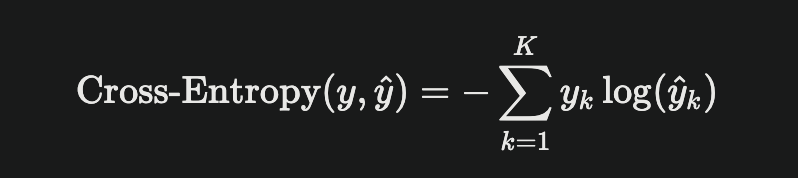

•⁠ Here, we use the Adam Optimizer because it adapts the learning rate for each parameter based on how frequently and strongly updated.

•⁠ In LR Scheduler, we have used LRonPlateau i.e. When the validation error plateaus, the LR will reduce by 0.5, after waiting for 10 epochs to check the variation in Validation.

•⁠ Ensures that if the L2 norm of gradients exceeds 1.0, they are scaled down proportionally.

# Training Epoch

- **Gradient Clipping**: Prevents exploding gradients by limiting gradient norm to 1.0
- **Early Stopping**: Halts training when validation accuracy stops improving


In [7]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Train a model with early stopping and learning rate scheduling
       Args ->
        model: NN model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Maximum number of training epochs (default: 100)
        learning_rate: Initial learning rate for optimizer (default: 0.001)
    """
    #CrossEntropyLoss Calculation (softmax + negative log likelihood) for multi-class classification
    criterion = nn.CrossEntropyLoss()
    #Adam for optimizing and L2 regularization to prevent overfitting
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler
    #ReduceLROnPlateau is used to reduce learning rate when valLoss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10 # min -> monitor valLoss ,factor -> reduce LR , patience -> wait 10 epochs before reducing LR
    )

    # Training history to store metrics for each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Here, early stopping is done to prevent overfitting
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 15

    print(f"Training {model.__class__.__name__} for {num_epochs} epochs...")

    #Iterate through each epoch
    for epoch in range(num_epochs):
        # Training phase
        model.train() #Training mode
        train_loss = 0.0 #init the training parameters
        train_correct = 0
        train_total = 0

        #Here, we are looping through the training data in small batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)#model predictions
            loss = criterion(outputs, batch_y)#calculating the loss
            loss.backward() # calculating the gradients

            # Gradient clipping to prevent exploding gradients
            # Ensures that if the L2 norm of gradients exceeds 1.0, they are scaled down proportionally
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step() #Updating the model
            #Updating the tracking parameters
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)#taking the index of the highest prob class
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # Validation phase - init testing parameters
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        #Evaluvating the model
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x) #Getting the model's predictions (no learning is happening)
                loss = criterion(outputs, batch_y)
                #To keep track of the test performance
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1) #Getting model's best guesses
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # Calculating the metrics
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Saving the results
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping and best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy() #Saving the current model state
            patience_counter = 0 #resetting the patience counter
        else:
            patience_counter += 1 #if there is no improvement in the validation accuracy increment the patience counter

        # Print  training progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Best Val Acc: {best_val_acc:.2f}%')
            print('-' * 50)

        # Early stopping check if there is no improvement for patience epochs
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load best model state(highest validation accuracy)
    model.load_state_dict(best_model_state)
     #Return training history and metrics
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

TRAINING THE MLP MODEL
----

In [8]:
# Training the MLP model
print("="*60)
print("TRAINING MLP MODEL")
print("="*60)

mlp_history = train_model(mlp_model, train_loader, val_loader, num_epochs=100, learning_rate=0.001)

# Saving the trained model
torch.save(mlp_model.state_dict(), 'mlp_model.pth')
print(f"MLP model saved. Best validation accuracy: {mlp_history['best_val_acc']:.2f}%")

TRAINING MLP MODEL
Training MLPModel for 100 epochs...


Epoch 1/100: 100%|██████████| 100/100 [00:00<00:00, 166.03it/s]


Epoch [1/100]
Train Loss: 2.1569, Train Acc: 25.06%
Val Loss: 1.8107, Val Acc: 33.00%
Best Val Acc: 33.00%
--------------------------------------------------


Epoch 10/100: 100%|██████████| 100/100 [00:00<00:00, 174.36it/s]


Epoch [10/100]
Train Loss: 0.6004, Train Acc: 78.56%
Val Loss: 1.1155, Val Acc: 60.25%
Best Val Acc: 60.25%
--------------------------------------------------


Epoch 20/100: 100%|██████████| 100/100 [00:00<00:00, 171.56it/s]


Epoch [20/100]
Train Loss: 0.1683, Train Acc: 95.34%
Val Loss: 1.0591, Val Acc: 66.12%
Best Val Acc: 66.12%
--------------------------------------------------


Epoch 30/100: 100%|██████████| 100/100 [00:00<00:00, 185.27it/s]


Epoch [30/100]
Train Loss: 0.1025, Train Acc: 96.97%
Val Loss: 1.2899, Val Acc: 64.38%
Best Val Acc: 66.12%
--------------------------------------------------


Epoch 40/100: 100%|██████████| 100/100 [00:00<00:00, 188.58it/s]


Epoch [40/100]
Train Loss: 0.0400, Train Acc: 98.84%
Val Loss: 1.3146, Val Acc: 66.12%
Best Val Acc: 67.00%
--------------------------------------------------


Epoch 50/100: 100%|██████████| 100/100 [00:00<00:00, 190.25it/s]


Epoch [50/100]
Train Loss: 0.0232, Train Acc: 99.19%
Val Loss: 1.3045, Val Acc: 66.12%
Best Val Acc: 68.38%
--------------------------------------------------


Epoch 60/100: 100%|██████████| 100/100 [00:00<00:00, 182.31it/s]


Epoch [60/100]
Train Loss: 0.0101, Train Acc: 99.84%
Val Loss: 1.3044, Val Acc: 67.25%
Best Val Acc: 68.38%
--------------------------------------------------


Epoch 64/100: 100%|██████████| 100/100 [00:00<00:00, 190.52it/s]

Early stopping at epoch 64
MLP model saved. Best validation accuracy: 68.38%


# Testing the MLP Model against the Kaggle Dataset

In [9]:
# Loading the test set
test_data = torch.load('testset_noLabels.pth',weights_only=False)
test = torch.stack([sample[0] for sample in test_data])

print(f"Test data shape: {test.shape}")

# Normalizing the test data using the same method as training data
X_test_normalized = normalize_data(test)

best_model = mlp_model
best_model_name = "MLP"
# Make predictions on test set
best_model.eval() #Setting the model to evaluation mode
test_predictions = []
with torch.no_grad(): #Disabling the gradient computation for testing
    # Processing test data in batches
    test_dataset = TensorDataset(X_test_normalized)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #Iterating through test batches
    for batch_x, in test_loader:
        batch_x = batch_x.to(device)
        outputs = best_model(batch_x)#Forward pass -> to get model prediction
        _, predicted = torch.max(outputs, 1)#Getting predicted classes
        test_predictions.extend(predicted.cpu().numpy())

print(f"Generated {len(test_predictions)} predictions")


submission_df = pd.DataFrame({
    'ID': range(len(test_predictions)),
    'Label': test_predictions
})
submission_df.to_csv('submission.csv', index=False)


Test data shape: torch.Size([1000, 40])
Generated 1000 predictions


# IMPLEMENTING CNN MODEL

Our CNN follows the below feature extraction pattern:

Conv Layers: 1 → 64 → 128 → 256 → 512 (Feature Map)

FC Layers: 512 → 256 → 128 → 10(Classification)

Each Convolution in our CNN includes ->


*   Conv1d layer for extraction
*   BatchNorm1d for normalization/regularization for stability

*   MaxPooling layer for downsampling
*   ReLU activation

Global Average Pooling
--
•⁠ Reduces Overfitting by eliminating spatial dimentions

Dropout Regularization
----
•⁠ 30% neurons dropped during training

•⁠ This prevents overfitting in dense layers

He Initialization
--
•⁠ We use He Initialization for init the initial weights

•⁠ This is optimal for ReLU activations

•⁠ Prevents vanishing/exploding gradients


We use unsqueeze() if 2D input is detected
  


In [10]:
#CNN Code
class CNNModel(nn.Module):
    """
    1D Convolutional Neural Network for time series classification

    Architecture:
    1D Convolutions: Extract  patterns in the dataset
    Max pooling: Downsample the dataset
    Multiple conv layers: Learning the  features
    Global average pooling: To reduce overfitting
    Fully connected layers: Final classification decision making
    """

    def __init__(self, input_length, num_classes=10, dropout_rate=0.3):
        super(CNNModel, self).__init__()
        #Store the model parameters
        self.input_length = input_length
        self.num_classes = num_classes


        # Conv1d: in_channels=1, out_channels=64
        # kernel_size=7 looks at 7 time steps at once, padding=3  to keep same length
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)#Batch Normalization for training stability
        self.pool1 = nn.MaxPool1d(kernel_size=2)#Reducing the  length by half

        # Takes 64 feature maps -> 128 new ones
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        #Increases feature maps to 256
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        #Final conv layer
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        #First FC layer : reduce form 512-> 256 features
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        # 256 -> 128
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        #Output layer that maps to the number of classes
        self.fc3 = nn.Linear(128, num_classes)


        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He initialization for ReLU """
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #Forward pass through the network
        if x.dim() == 2:
            x = x.unsqueeze(1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x))) #conv-> BatchNorm -> ReLu activation
        x = self.pool1(x)#Maxpooling

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))

        # Global average pooling
        x = self.global_avg_pool(x)  # [batch, 512, 1]
        x = x.squeeze(-1)  # [batch, 512]

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

# Create CNN model
cnn_model = CNNModel(input_length=input_size).to(device)
print(f"CNN Model:\n{cnn_model}")

# Counting the parameters
total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

CNN Model:
CNNModel(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_f

Training the CNN Model
----

In [11]:
# Training the CNN model
print("="*60)
print("TRAINING CNN MODEL")
print("="*60)

cnn_history = train_model(cnn_model, train_loader, val_loader, num_epochs=100, learning_rate=0.001)

# Saving the trained model
torch.save(cnn_model.state_dict(), 'cnn_model.pth')
print(f"CNN model saved. Best validation accuracy: {cnn_history['best_val_acc']:.2f}%")

TRAINING CNN MODEL
Training CNNModel for 100 epochs...


Epoch 1/100: 100%|██████████| 100/100 [00:03<00:00, 31.34it/s]


Epoch [1/100]
Train Loss: 2.3273, Train Acc: 50.25%
Val Loss: 1.0197, Val Acc: 67.12%
Best Val Acc: 67.12%
--------------------------------------------------


Epoch 10/100: 100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


Epoch [10/100]
Train Loss: 0.1351, Train Acc: 96.03%
Val Loss: 0.3882, Val Acc: 90.75%
Best Val Acc: 93.38%
--------------------------------------------------


Epoch 20/100: 100%|██████████| 100/100 [00:03<00:00, 31.57it/s]


Epoch [20/100]
Train Loss: 0.0648, Train Acc: 97.97%
Val Loss: 0.2422, Val Acc: 94.12%
Best Val Acc: 95.12%
--------------------------------------------------


Epoch 30/100: 100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


Epoch [30/100]
Train Loss: 0.0048, Train Acc: 99.88%
Val Loss: 0.1917, Val Acc: 95.50%
Best Val Acc: 97.00%
--------------------------------------------------


Epoch 40/100: 100%|██████████| 100/100 [00:03<00:00, 31.78it/s]


Epoch [40/100]
Train Loss: 0.0058, Train Acc: 99.84%
Val Loss: 0.1692, Val Acc: 96.75%
Best Val Acc: 97.00%
--------------------------------------------------


Epoch 44/100: 100%|██████████| 100/100 [00:03<00:00, 32.21it/s]


Early stopping at epoch 44
CNN model saved. Best validation accuracy: 97.00%


Testing CNN Model against Kaggle Dataset
----

In [12]:
# Loading the test set
test_data = torch.load('testset_noLabels.pth',weights_only=False)
test = torch.stack([sample[0] for sample in test_data])

print(f"Test data shape: {test.shape}")

# Normalizing test data using the same method as training data
X_test_normalized = normalize_data(test)

best_model = cnn_model
best_model_name = "CNN"
# Making predictions on test set
best_model.eval()
test_predictions = []
with torch.no_grad():
    # Process in batches
    test_dataset = TensorDataset(X_test_normalized)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for batch_x, in test_loader:
        batch_x = batch_x.to(device)
        outputs = best_model(batch_x)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())

print(f"Generated {len(test_predictions)} predictions")


submission_df = pd.DataFrame({
    'ID': range(len(test_predictions)),
    'Label': test_predictions
})
submission_df.to_csv('submissioncnnss.csv', index=False)


Test data shape: torch.Size([1000, 40])
Generated 1000 predictions


# RESULTS COMPARITIVE STUDY


TRAINING LOSS COMPARISON
-----

As, We observed the training loss of both the models as the epocha increased CNN has a sharp dip in the training loss than MLP .

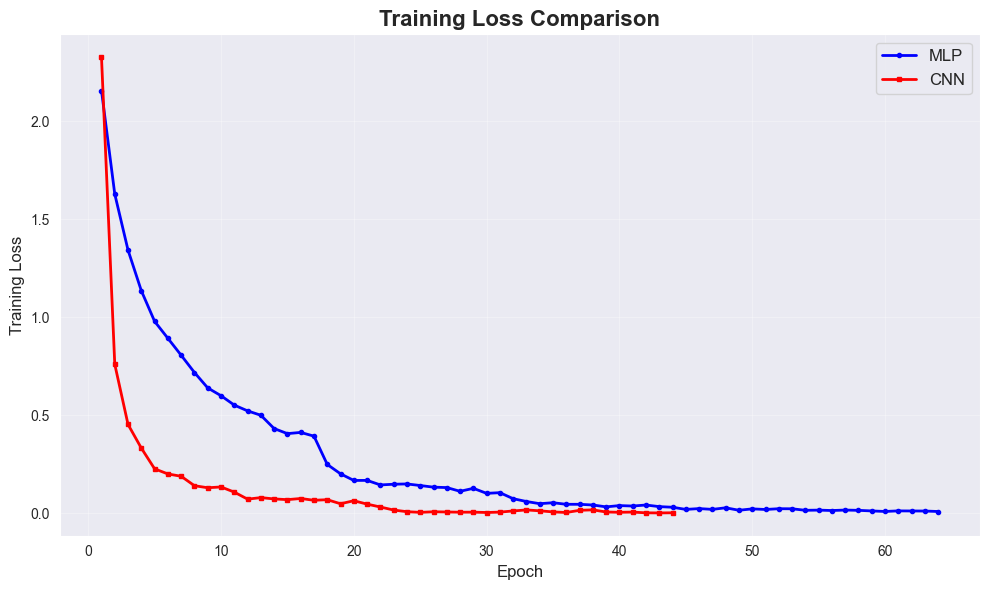

In [13]:
"""Plot training loss comparison between MLP and CNN"""
plt.figure(figsize=(10, 6))

epochs_mlp = range(1, len(mlp_history['train_losses']) + 1)
epochs_cnn = range(1, len(cnn_history['train_losses']) + 1)

plt.plot(epochs_mlp, mlp_history['train_losses'], 'b-', label='MLP', linewidth=2, marker='o', markersize=3)
plt.plot(epochs_cnn, cnn_history['train_losses'], 'r-', label='CNN', linewidth=2, marker='s', markersize=3)

plt.title('Training Loss Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

VALIDATION ACCURACY GRAPH
-----
From the Graph it is clear that CNN has more validation accuracy than MLP because  CNN is better at generalizing image patterns compared to MLPs.


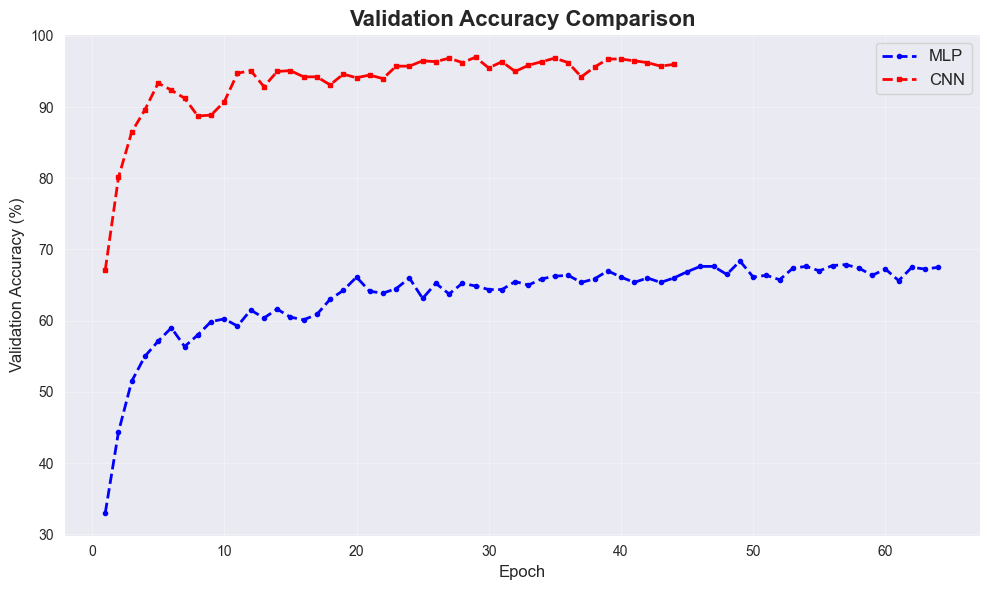

In [14]:
"""Plot validation accuracy comparison between MLP and CNN"""
plt.figure(figsize=(10, 6))

epochs_mlp = range(1, len(mlp_history['val_accuracies']) + 1)
epochs_cnn = range(1, len(cnn_history['val_accuracies']) + 1)

plt.plot(epochs_mlp, mlp_history['val_accuracies'], 'b--', label='MLP', linewidth=2, marker='o', markersize=3)
plt.plot(epochs_cnn, cnn_history['val_accuracies'], 'r--', label='CNN', linewidth=2, marker='s', markersize=3)

plt.title('Validation Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

PERFORMANCE COMPARISON OF BOTH MODELS
-------


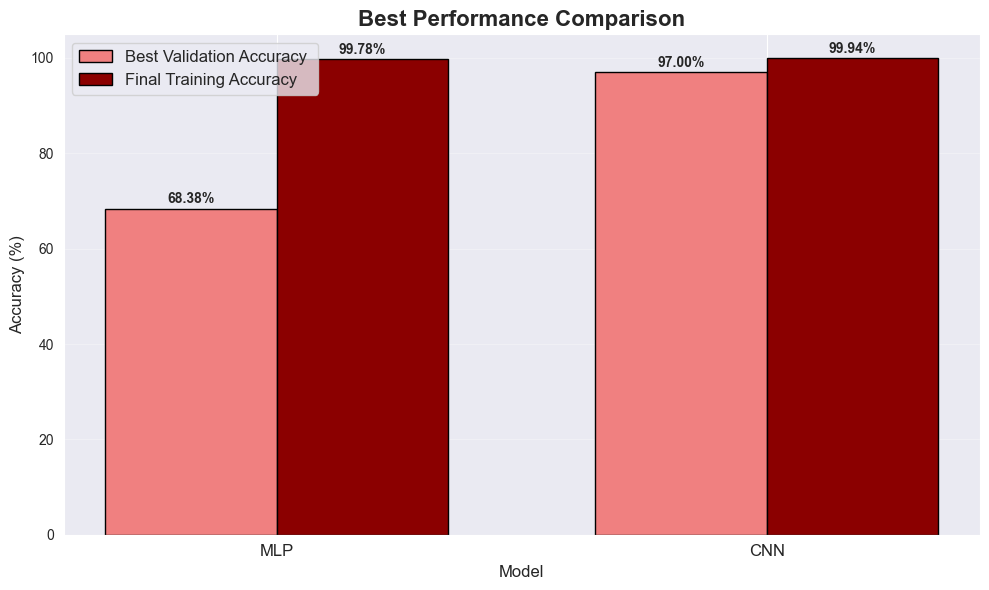

In [15]:
"""Plot best performance comparison bar chart"""
plt.figure(figsize=(10, 6))

models = ['MLP', 'CNN']
best_val_accs = [mlp_history['best_val_acc'], cnn_history['best_val_acc']]
final_train_accs = [mlp_history['train_accuracies'][-1], cnn_history['train_accuracies'][-1]]

x = np.arange(len(models))
width = 0.35

bars1 = plt.bar(x - width/2, best_val_accs, width, label='Best Validation Accuracy ',
                color=['lightcoral', 'lightcoral'], edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, final_train_accs, width, label='Final Training Accuracy ',
                color=['darkred', 'darkred'], edgecolor='black', linewidth=1)

plt.title('Best Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(x, models, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (val_acc, train_acc) in enumerate(zip(best_val_accs, final_train_accs)):
    plt.text(i - width/2, val_acc + 0.5, f'{val_acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, train_acc + 0.5, f'{train_acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

LEARNING CURVE GRAPH CNN VS MLP
----

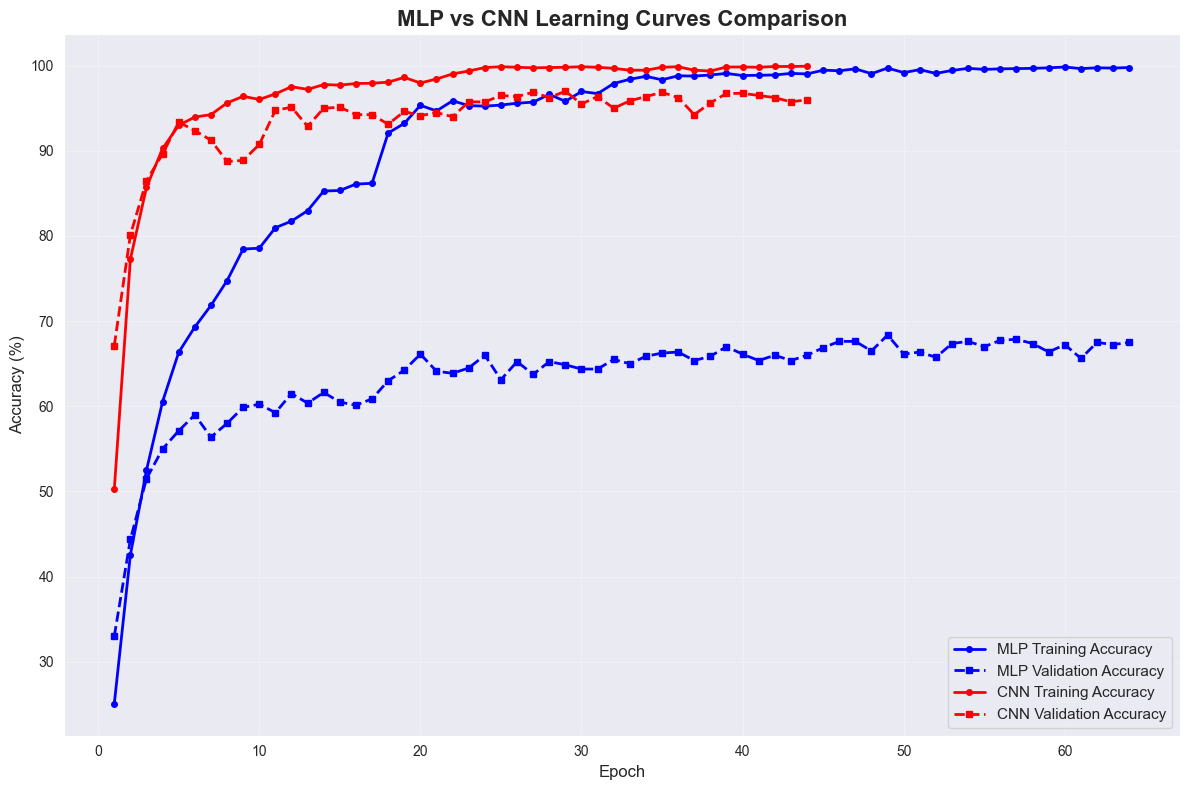

In [16]:
plt.figure(figsize=(12, 8))

# Get epochs for both models
mlp_epochs = range(1, len(mlp_history['train_accuracies']) + 1)
cnn_epochs = range(1, len(cnn_history['train_accuracies']) + 1)

# Plot MLP curves
plt.plot(mlp_epochs, mlp_history['train_accuracies'], 'b-',
         label='MLP Training Accuracy', linewidth=2, marker='o', markersize=4)
plt.plot(mlp_epochs, mlp_history['val_accuracies'], 'b--',
         label='MLP Validation Accuracy', linewidth=2, marker='s', markersize=4)

# Plot CNN curves
plt.plot(cnn_epochs, cnn_history['train_accuracies'], 'r-',
         label='CNN Training Accuracy', linewidth=2, marker='o', markersize=4)
plt.plot(cnn_epochs, cnn_history['val_accuracies'], 'r--',
         label='CNN Validation Accuracy', linewidth=2, marker='s', markersize=4)

plt.title('MLP vs CNN Learning Curves Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
with open("README.md", "w") as f:
    f.write("**Wigglies Classification using Neural Networks**\n\n")
    f.write("This code contains a comprehensive implementation of two neural network architectures for classifying 'wigglies' data using PyTorch.\n\n")

    f.write("**Overview**\n\n")
    f.write("The implementation demonstrates advanced neural network techniques for multi-class classification with:\n")
    f.write(" * Multi-Layer Perceptron (MLP) - Fully connected feed-forward network\n")
    f.write(" * Convolutional Neural Network (CNN) - Spatial pattern recognition architecture\n")
    f.write(" * Comprehensive data preprocessing and normalization\n")
    f.write(" * Model comparison and evaluation metrics\n")
    f.write(" * GPU/CPU acceleration support\n\n")

    f.write("**Prerequisites**\n\n")
    f.write("Install the required Python libraries:\n\n")
    f.write("```bash\npip install torch torchvision numpy matplotlib scikit-learn seaborn pandas tqdm\n```\n\n")

    f.write("**File Structure**\n\n")
    f.write("* `Portfolio_Wigglies_Riya_Harsha.ipynb` - Contains the complete, commented source code for both neural network implementations\n")
    f.write("* `trainset.pth` - Training dataset with labeled samples\n")
    f.write("* `testset_noLabels.pth` - Test dataset for final predictions\n")
    f.write("* `submission.csv` - Generated predictions for test set\n\n")

    f.write("**Key Components**\n\n")

    f.write("1. **Data Loading and Preprocessing**\n")


    f.write("2. **MLP Model Architecture**\n")


    f.write("3. **CNN Model Architecture**\n")


    f.write("4. **Training Pipeline**\n")


    f.write("5. **Model Evaluation**\n")
    f.write("6. **Final Predictions and Comparison Plots**\n")

    f.write("**Acknowledgment**\n\n")
    f.write("Thanks to Prof. Dr. Magda Gregorova for providing insightful lectures on Deep Learning and giving us these interesting and fun assignments.\n")